# 自动售货机画像

1. 给出每台售货机所有商品的商品标签（包括非饮料和饮料），保存于csv文件中，文件名分别为task3-1A.csv……（任务3.1修改版）
2. 标签扩展（任务3.2）
3. 生成画像（任务3.2）

## 0. 加载模块

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import PIL.Image as Image
from wordcloud import WordCloud

## 1. 添加商品标签

In [4]:
#首先对数据进行分析
f=open('../数据/初步处理数据.csv')
data=pd.read_csv(f)
sales_volume=data['商品'].value_counts() #销量数据，默认有排序
print('最大值：',np.max(sales_volume))
print('最小值：',np.min(sales_volume))

最大值： 4964
最小值： 1


In [5]:
#对销量数据做分割，以便查看分布情况
bins=np.linspace(0,5000,11)  #分割数据的依据
data_cut = pd.cut(sales_volume.values,bins)  #分割数据
number=pd.value_counts(data_cut,sort=False)  #统计每段的数据个数

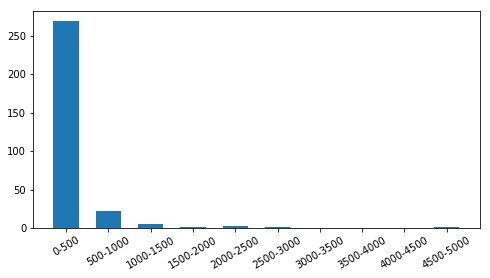

In [6]:
#绘制柱状图，更加直观
names=['0-500','500-1000','1000-1500','1500-2000','2000-2500','2500-3000','3000-3500','3500-4000','4000-4500','4500-5000']
x=range(10)
plt.subplots(figsize = (8,4))
plt.bar(x,number.values,width=0.6)
plt.xticks(x, names,rotation=30)
plt.savefig('../图片/画像/销量柱状图.png',dpi=500,bbox_inches='tight')
plt.show()

由柱状图可以看出，绝大部分数据分布在0-500之间，取500为总销量的上限，即总销量大于500可认为是热销

总销量的下限取0-500内商品销量的中位数，即总销量小于该值可认为是滞销

In [7]:
lower_limit=np.percentile(sales_volume[sales_volume<=500],50)/5  #取中位数，并平均分配到5个地区
upper_limit=500/5 #上限

In [8]:
#函数，用于比较数值，判断标签
def compare(num):
    if num<lower_limit:
        return '滞销'
    elif num>upper_limit:
        return '热销'
    else:
        return '正常'
    
place=['A','B','C','D','E']
for pla in place:
    f=open('../数据/分割数据/task1-1'+pla+'.csv')
    place_data=pd.read_csv(f)
    place_sales_volume=place_data.groupby(place_data['商品']).size() #商品销量数据
    new_data=pd.DataFrame(np.array([place_sales_volume.index,place_sales_volume.values]).T,
                   index=range(len(place_sales_volume)),columns=['商品','销量']) #生成DataFrame型数据
    new_data['标签']=list(map(lambda x: compare(x), new_data['销量']))
    new_data.to_csv('../数据/任务3-1/task3-1'+pla+'.csv', encoding='gbk',index=None)

#以E地区的数据为例
new_data.head()

,商品,销量,标签
0,100g*5瓶益力多,53,正常
1,100g卫龙点心面黑椒牛排味,9,滞销
2,100g果王咸柑桔罐装,14,正常
3,103g康师傅红烧牛肉面,17,正常
4,107g出前一丁桶面酱香牛肉王,12,正常


## 2. 标签扩展

In [9]:
#首先对附件2的“二级类”属性做出修改，对商品做出更准确的分类，如将“劲仔小鱼”的二级类由“肉干/豆制品/蛋”修改为“肉干”
f=open('../数据/附件2 - 修改.csv')
info_data=pd.read_csv(f)
first_type=dict(map(lambda x,y:[x,y],list(info_data['商品']),list(info_data['标签1'])))  #生成字典

#然后使用正则表达式去除商品列的字母、数字和其它字符等
r1 = '[a-zA-Z0-9*_瓶（）/()+]'
info_data['标签2']=list(map(lambda x: re.sub(r1, '', x),info_data['商品']))
second_type=dict(map(lambda x,y:[x,y],list(info_data['商品']),list(info_data['标签2'])))

In [10]:
#将生成的标签添加到csv中
for pla in place:
    f=open('../数据/任务3-1/task3-1'+pla+'.csv')
    place_data=pd.read_csv(f)
    place_data['标签1']=place_data['商品'].map(first_type)
    place_data['标签2']=place_data['商品'].map(second_type)
    place_data.to_csv('../数据/任务3-2/task3-2'+pla+'.csv', encoding='gbk',index=None)

#以E地区的数据为例
place_data.head()

,商品,销量,标签,标签1,标签2
0,100g*5瓶益力多,53,正常,乳制品,益力多
1,100g卫龙点心面黑椒牛排味,9,滞销,豆制品,卫龙点心面黑椒牛排味
2,100g果王咸柑桔罐装,14,正常,果干,果王咸柑桔罐装
3,103g康师傅红烧牛肉面,17,正常,方便速食,康师傅红烧牛肉面
4,107g出前一丁桶面酱香牛肉王,12,正常,方便速食,出前一丁桶面酱香牛肉王


## 3. 生成画像

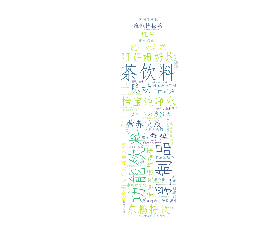

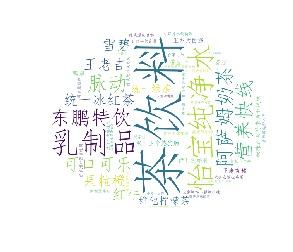

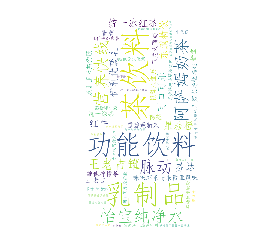

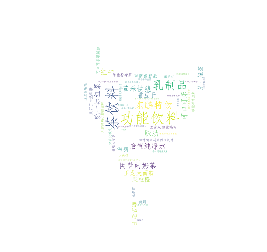

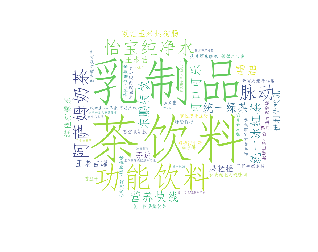

In [4]:
place=['A','B','C','D','E']
for pla in place:    
    f=open('../数据/任务3-2/task3-2'+pla+'.csv')
    place_data=pd.read_csv(f)
    counts1 = {}  #创建字典，保存标签1
    counts2 = {}  #保存标签2
    for i in range(place_data.shape[0]):
        counts1[place_data['标签1'][i]] = counts1.get(place_data['标签1'][i],0) + place_data['销量'][i]
        counts2[place_data['标签2'][i]] = counts2.get(place_data['标签2'][i],0) + place_data['销量'][i]
    items1 = list(counts1.items())   #返回所有键值对
    items2 = list(counts2.items())
    items1.sort(key=lambda x:x[1], reverse =True) #排序
    items2.sort(key=lambda x:x[1], reverse =True)
    
    wordlist=list()
    for i in range(3):  #该类标签合并后只有24个，因此选取前3个词，代表了销量最好的几类商品
        word,count = items1[i]  
        wordlist.append(word) 
    for i in range(50):  #选取前50个词
        word,count = items2[i]  
        wordlist.append(word)    #把词语word放进一个列表

    wl=' '.join(wordlist)

    #图片遮罩层
    mask_pic=np.array(Image.open('../图片/画像/遮罩图片/'+pla+'.jpg'))
    wc = WordCloud(font_path="C:/Windows/Fonts/simfang.ttf",
                          background_color="white",
                          mask=mask_pic).generate(wl)
    #显示图片
    plt.imshow(wc)
    plt.axis('off')        #关闭坐标
    plt.show()
    wc.to_file('../图片/画像/地区'+pla+'.png') #保存